In [1]:
import tensorflow as tf
import cv2 as cv
import numpy as np
import os
from os.path import join
import matplotlib.pyplot as plt
from functions import analyse
from datetime import datetime as dt
from cnn_load_data import load_labels as old_load_labels

In [2]:
class rnnClassify:
    def __init__(self, n_classes=2, hm_epochs=25, keep_rate=0.8):
        tf.reset_default_graph()
        self.n_classes = n_classes
        self.hm_epochs = hm_epochs
        self.keep_rate = keep_rate
        self.keep_prob = tf.placeholder(tf.float32)
        # Weight variables and input placeholders
        self.x = tf.placeholder(tf.float32, [24, 24, 3])
        self.y = tf.placeholder(tf.float32, [2])
        self.weights = {'W_conv1':tf.Variable(tf.random_normal([5,5,3,32]),name='W_conv1'),
                        'W_conv2':tf.Variable(tf.random_normal([5,5,32,64]),name='W_conv2'),
                        'W_fc':tf.Variable(tf.random_normal([6*6*64, 1024]),name='W_fc'),
                        'W_out':tf.Variable(tf.random_normal([1024, self.n_classes]),name='W_out')}
        self.biases = {'b_conv1':tf.Variable(tf.random_normal([32]),name='b_conv1'),
                       'b_conv2':tf.Variable(tf.random_normal([64]),name='b_conv2'),
                       'b_fc':tf.Variable(tf.random_normal([1024]),name='b_fc'),
                       'b_out':tf.Variable(tf.random_normal([self.n_classes]),name='b_out')}
        # Cost optimizer
        self.model = self.rnn_model()
        self.cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=self.model, labels=self.y) )
        self.train_op = tf.train.AdamOptimizer().minimize(self.cost)
        # Auxiliary ops
        self.saver = tf.train.Saver()
        
    def frame_stamp(self):
        current = dt.now()
        out_str = (str(current.year) + str(current.month) + str(current.day) + "_" + 
                   str(current.hour) + str(current.minute) + str(current.second) + "_" +
                   str(current.microsecond))
        return out_str

    def pad(self, arr):
        r = np.zeros((24,24,3))
        r[:arr.shape[0],:arr.shape[1],:arr.shape[2]] = arr
        return r

    def split_arr(self, arr, percent):
        position = int(len(arr) * (1-percent))
        train_data = arr[:position]
        test_data = arr[position:]
        self.train_data_x, self.train_data_y = self.extract_x_y(train_data)
        self.test_data_x, self.test_data_y = self.extract_x_y(test_data)
    
    def extract_x_y(self, arr):
        x = arr[:,0]
        y = arr[:,1]
        return x,y
    
    def load_labels(self):
        fdir = "seq_labels"
        dataset = []
        count = 0
        none_count = 0
        last_frame = 0
        last_seq = 0
        for file in os.listdir(fdir):
            if file.endswith(".jpg"):
                img = cv.imread(os.path.join(fdir,file), cv.IMREAD_UNCHANGED)
                if not img is None:
                    img = pad(img)
                    file_params = file.split("_")                
                    ## Check if labeled as ball
                    tmp_dataset = []
                    if file_params[0] == 0:    
                        tmp_dataset.append(img) #0
                        tmp_dataset.append(np.array([0,1])) #1
                    else:
                        tmp_dataset.append(img) #0
                        tmp_dataset.append(np.array([1,0])) #1
                    ## Get seqence ID
                    current_seq = int(file_params[1])
                    tmp_dataset.append(current_seq) #2
                    if current_seq != last_seq:
                        last_frame = 0
                        last_seq = current_seq
                    ## Get frame number (Will decide if frame number or difference is more useful later on)
                    print(file_params[2])
                    current_frame = int(file_params[2])
                    tmp_dataset.append(current_frame) #3
                    ## Get frame difference
                    if last_frame == 0:
                        tmp_dataset.append(0)
                    else:
                        tmp_dataset.append(current_frame - last_frame)
                    last_frame = current_frame
                    ## Get coordinates
                    tmp_dataset.append( [int( file_params[3]),int(file_params[4])] )
                    ## Get time difference from last frame
                    dataset.append([tmp_dataset])
                else:
                    none_count += 1
                count += 1
            if count == 5:
                print("Breaking, count == 5")
                break
        print("None count: ", none_count, " | Images loaded: ", count)
        return np.array(dataset)
       
    def conv2d(self, tf_in, W, b):
        conv = tf.nn.conv2d(tf_in, W, strides=[1,1,1,1], padding='SAME')
        conv_with_b = tf.nn.bias_add(conv, b)
        conv_out = tf.nn.relu(conv_with_b)
        return conv_out

    def maxpool2d(self,tf_in):
        return tf.nn.max_pool(tf_in, ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME')
    
    def rnn_load_data(self):
        data = old_load_labels()
        #data = self.load_labels()
        np.random.shuffle(data)
        self.split_arr(data, 0.25)
        print("Traing_data count: ", len(self.train_data_x))
        print("Test_data count: ", len(self.test_data_x))
        
    def rnn_model(self):
        # 5 x 5, 3 input, produces 32 features
        x_tf = tf.reshape(self.x, shape=[-1,24,24,3])
        conv1 = self.maxpool2d(self.conv2d(x_tf, self.weights['W_conv1'], self.biases['b_conv1']))
        conv2 = self.maxpool2d(self.conv2d(conv1, self.weights['W_conv2'], self.biases['b_conv2']))
        fc = tf.reshape(conv2,[-1,6*6*64])
        fc = tf.nn.relu(tf.matmul(fc, self.weights['W_fc']) + self.biases['b_fc'])
        fc = tf.nn.dropout(fc, self.keep_rate)
        output = tf.matmul(fc, self.weights['W_out']) + self.biases['b_out']
        return output
    
    def rnn_train(self, zero_catch=0):    
        with tf.Session() as sess:
            tf.get_variable_scope().reuse_variables()
            sess.run(tf.global_variables_initializer())
            self.loss_plot = []
            hm_zeros = 0
            for epoch in range(self.hm_epochs):
                c = 0
                for i in range(len(self.train_data_x)):
                    _, c_tmp = sess.run([self.train_op, self.cost], feed_dict = {self.x: self.train_data_x[i], self.y: self.train_data_y[i]})
                    c += c_tmp
                self.loss_plot.append(c)
                print('Epoch: ', epoch, ' completed out of: ', self.hm_epochs, ' loss: ', c)
                if (zero_catch > 0) and (c == 0):
                    hm_zeros += 1
                    if hm_zeros == zero_catch:
                        print("Reached zero catch of: ", zero_catch)
                        break
                elif (c != 0):
                    hm_zeros = 0  
            location = 'C:/Users/joear/OneDrive - Imperial College London/General/Code/Python/EDP/rnn_model/'
            save_path = self.saver.save(sess, location + "current_model.ckpt")
            print("Model saved in path: %s" % save_path)
    
    def calculate_accuracy(self, cumm_acc, curr_result, true_result, tp,tn,fp,fn):
        if true_result == 1 and curr_result == 0:
            fn += 1
        elif true_result == 0 and curr_result == 0:
            fp += 1
        elif true_result == 1 and curr_result == 1:
            tp += 1
        elif true_result == 0 and curr_result == 1:
            tn += 1
        cumm_acc += curr_result
        return cumm_acc, tp,tn,fp,fn
    
    def print_accuracy(self, length, cumm_acc, tp,tn,fp,fn):
        print("=======================================")
        print("Accuracy: ", cumm_acc/length*100)
        print("Tests: ", length)
        print("Positive Sample: ", tp + fn)
        print("Negative Sample: ", fp + tn)
        print("Incorrect: ", fp + fn)
        print("---------------------------------------")
        print("False Positives: ", fp)
        print("False Negatives: ", fn)
        print("True  Positives: ", tp)
        print("True  Negatives: ", tn)
        print("=======================================")
        plt.plot(self.loss_plot)
        plt.show()
    
    def rnn_test(self):
        # Check how good model is
        with tf.Session() as sess:
            tf.get_variable_scope().reuse_variables()
            location = 'C:/Users/joear/OneDrive - Imperial College London/General/Code/Python/EDP/rnn_model/'
            self.saver.restore(sess, location + "current_model.ckpt")
            print("Model restored")
            print("---------------------------------------")
            cumm_acc = tp=tn=fp=fn = 0
            length = len(self.test_data_x)
            for i in range(length):
                output = sess.run(self.rnn_model(), feed_dict={self.x: self.test_data_x[i]})
                curr_result = 0
                true_result = self.test_data_y[i].argmax(axis=0)
                if (output.argmax(axis=1)[0] == self.test_data_y[i].argmax(axis=0) ): curr_result = 1
                cumm_acc,tp,tn,fp,fn = self.calculate_accuracy(cumm_acc, curr_result, true_result, tp,tn,fp,fn)
            self.print_accuracy(length, cumm_acc, tp,tn,fp,fn)
            
                
    def rnn_predict(self, predict_data_x):
        with tf.Session() as sess:
            tf.get_variable_scope().reuse_variables()
            location = 'C:/Users/joear/OneDrive - Imperial College London/General/Code/Python/EDP/rnn_model/'
            self.saver.restore(sess, location + "current_model.ckpt")
            print("Model restored")
            print("---------------------------------------")
            acc = true_pos = true_neg = false_pos = false_neg = 0
            if (type(predict_data_x[0][0][0]).__name__ == 'float64'):
                output = sess.run(self.rnn_model(), feed_dict={self.x: predict_data_x})
                return output
            elif (type(predict_data_x[0][0][0][0]).__name__ == 'float64'):
                output = []
                length = len(self.test_data_x)
                for i in range(length):
                    if (i % 50 == 0): print("Progress: ", i/length * 100)
                    output.append(sess.run(self.rnn_model(), feed_dict={self.x: predict_data_x[i]}))
                return output


None count:  14
Traing_data count:  1847
Test_data count:  616
-------
Epoch:  0  completed out of:  50  loss:  453053600.742
Epoch:  1  completed out of:  50  loss:  144161954.563
Epoch:  2  completed out of:  50  loss:  35592682.1094
Epoch:  3  completed out of:  50  loss:  42747477.3594
Epoch:  4  completed out of:  50  loss:  28768092.75
Epoch:  5  completed out of:  50  loss:  24086932.125
Epoch:  6  completed out of:  50  loss:  16978649.1875
Epoch:  7  completed out of:  50  loss:  12092835.4063
Epoch:  8  completed out of:  50  loss:  0.0
Epoch:  9  completed out of:  50  loss:  16064527.6875
Epoch:  10  completed out of:  50  loss:  6684898.375
Epoch:  11  completed out of:  50  loss:  0.0
Epoch:  12  completed out of:  50  loss:  0.0
Reached zero catch of:  2
Model saved in path: C:/Users/joear/OneDrive - Imperial College London/General/Code/Python/EDP/rnn_model/current_model.ckpt
-------
INFO:tensorflow:Restoring parameters from C:/Users/joear/OneDrive - Imperial College Lon

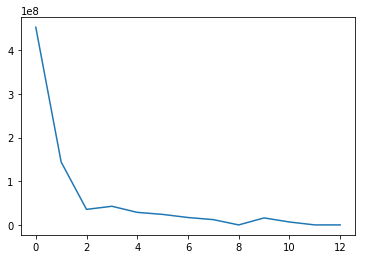

In [3]:
if __name__ == '__main__':
    predictor = rnnClassify(hm_epochs=50)
    predictor.rnn_load_data()
    print('-------')
    predictor.rnn_train(zero_catch=2)
    print('-------')
    predictor.rnn_test()